In [118]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /Users/sven/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sven/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sven/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sven/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/sven/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [119]:
# Load the data
data_file = "training_data_lowercase.csv"
data = pd.read_csv(data_file, sep="\t", header=None)  # Load as tab-delimited file without headers

In [120]:
# Assign new column names
data.columns = ['label', 'text']

data.head(5)

,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [121]:
# Remove special characters
data['text'] = data['text'].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [122]:
# Define a set of common English stopwords using NLTK's predefined list.
stop_words = set(stopwords.words('english'))

In [123]:
# Tokenize and remove stopwords for each text entry in the dataframe
data['filtered_text'] = data['text'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

In [124]:
# Lemmatization of text to leverage the context as well

# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get part-of-speech (POS) tagging for more accurate lemmatization
def get_wordnet_pos(word):
    from nltk.corpus import wordnet
    from nltk import pos_tag
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  # Adjective
        'N': wordnet.NOUN,  # Noun
        'V': wordnet.VERB,  # Verb
        'R': wordnet.ADV   # Adverb
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun

# Apply lemmatization to the filtered_text column
data['lemmatized_text'] = data['filtered_text'].apply(
    lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
)

# Display the first few rows to verify the result
print(data.head())



   label                                               text  \
0      0  donald trump sends out embarrassing new years ...   
1      0  drunk bragging trump staffer started russian c...   
2      0  sheriff david clarke becomes an internet joke ...   
3      0  trump is so obsessed he even has obamas name c...   
4      0  pope francis just called out donald trump duri...   

                                       filtered_text  \
0  [donald, trump, sends, embarrassing, new, year...   
1  [drunk, bragging, trump, staffer, started, rus...   
2  [sheriff, david, clarke, becomes, internet, jo...   
3  [trump, obsessed, even, obamas, name, coded, w...   
4  [pope, francis, called, donald, trump, christm...   

                                     lemmatized_text  
0  [donald, trump, sends, embarrass, new, year, e...  
1  [drunk, bragging, trump, staffer, start, russi...  
2  [sheriff, david, clarke, becomes, internet, jo...  
3  [trump, obsess, even, obamas, name, cod, websi...  
4  [pope,

In [125]:
# Combine tokens into single text strings for each row in 'lemmatized_text'
data['lemmatized_text'] = data['lemmatized_text'].apply(lambda tokens: ' '.join(tokens))

print(data['lemmatized_text'])

0        donald trump sends embarrass new year eve mess...
1        drunk bragging trump staffer start russian col...
2        sheriff david clarke becomes internet joke thr...
3          trump obsess even obamas name cod website image
4          pope francis call donald trump christmas speech
                               ...                        
34147              tear rain thai gather late king funeral
34148    pyongyang university need nonus teacher travel...
34149    philippine president duterte visit japan ahead...
34150             japan abe may election many dont want pm
34151      demoralize divide inside catalonia police force
Name: lemmatized_text, Length: 34152, dtype: object


In [126]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  
    stop_words='english',  # Exclude common stopwords 
    ngram_range=(1, 2)  # Consider unigrams and bigrams 
)

In [127]:
# Fit and transform the lemmatized text column
tfidf_matrix = tfidf_vectorizer.fit_transform(data['lemmatized_text'])

In [128]:
# Convert the resulting sparse matrix to a DataFrame for analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [129]:
# Display the first few rows of the TF-IDF DataFrame
print(tfidf_df.head(50))

     10  10 billion  10 day  10 million  10 year  100  100 day  100 million  \
0   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
1   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
2   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
3   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
4   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
5   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
6   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
7   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
8   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
9   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
10  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
11  0.0         0.0     0.0         0.0      0.0  0.

In [130]:
X = tfidf_df  # Feature set
y = data['label']  

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9292929292929293
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      3529
           1       0.92      0.94      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831



In [132]:
# Display summary statistics of the lengths of lemmatized text entries to understand the distribution of text size
print(data['lemmatized_text'].apply(len).describe())

count    34152.000000
mean        59.058562
std         17.687234
min          0.000000
25%         49.000000
50%         57.000000
75%         67.000000
max        229.000000
Name: lemmatized_text, dtype: float64


In [133]:
# Count and display the number of missing (NaN) values in the 'lemmatized_text' column to check data completeness
print("Number of NaN values:", data['lemmatized_text'].isna().sum())

Number of NaN values: 0


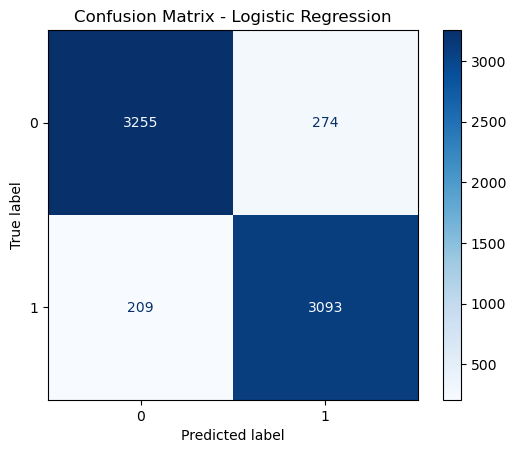

In [134]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  # Adjust parameters if needed
logistic_model.fit(X_train, y_train)

# Step 2: Generate predictions
y_pred_logistic = logistic_model.predict(X_test)

# Step 3: Compute the confusion matrix
cm_logistic = confusion_matrix(y_test, y_pred_logistic)

# Step 4: Display the confusion matrix
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=logistic_model.classes_)
disp_logistic.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [135]:
# Load the testing dataset (update file path accordingly)
testing_data_file = "testing_data_lowercase_nolabels.csv"
testing_data = pd.read_csv(testing_data_file, sep="\t", header=None)  # Tab-separated
testing_data.columns = ['label', 'text']


In [136]:
# Remove special characters
testing_data['text'] = testing_data['text'].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [137]:
# Tokenize and remove stopwords for each text entry in the dataframe
testing_data['filtered_text'] = testing_data['text'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

In [138]:
# Lemmatization of text to leverage the context as well

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get part-of-speech (POS) tagging for more accurate lemmatization
def get_wordnet_pos(word):
    from nltk.corpus import wordnet
    from nltk import pos_tag
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  # Adjective
        'N': wordnet.NOUN,  # Noun
        'V': wordnet.VERB,  # Verb
        'R': wordnet.ADV   # Adverb
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun

# Apply lemmatization to the filtered_text column
testing_data['lemmatized_text'] = testing_data['filtered_text'].apply(
    lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
)

# Display the first few rows to verify the result
print(testing_data.head())


  label                                               text  \
0     2  copycat muslim terrorist arrested with assault...   
1     2  wow chicago protester caught on camera admits ...   
2     2     germanys fdp look to fill schaeubles big shoes   
3     2  mi school sends welcome back packet warning ki...   
4     2  un seeks massive aid boost amid rohingya emerg...   

                                       filtered_text  \
0  [copycat, muslim, terrorist, arrested, assault...   
1  [wow, chicago, protester, caught, camera, admi...   
2  [germanys, fdp, look, fill, schaeubles, big, s...   
3  [mi, school, sends, welcome, back, packet, war...   
4  [un, seeks, massive, aid, boost, amid, rohingy...   

                                     lemmatized_text  
0  [copycat, muslim, terrorist, arrest, assault, ...  
1  [wow, chicago, protester, caught, camera, admi...  
2  [germany, fdp, look, fill, schaeubles, big, shoe]  
3  [mi, school, sends, welcome, back, packet, war...  
4  [un, seek, m

In [139]:
# Combine tokens into single text strings for each row in 'lemmatized_text'
testing_data['lemmatized_text'] = testing_data['lemmatized_text'].apply(lambda tokens: ' '.join(tokens))

print(testing_data['lemmatized_text'])

0          copycat muslim terrorist arrest assault weapon
1       wow chicago protester caught camera admits vio...
2               germany fdp look fill schaeubles big shoe
3       mi school sends welcome back packet warn kid w...
4       un seek massive aid boost amid rohingya emerge...
                              ...                        
9979    boom fox news leftist chris wallace attempt tr...
9980    list democrat hypocrite vote filibuster gw bus...
9981    new fire ravage rohingya village northwest mya...
9982    meal wheel shuts lyin lefty truth moveonorgs f...
9983    brilliant tucker carlson ayaan hirsi ali discu...
Name: lemmatized_text, Length: 9984, dtype: object


In [146]:
# Fit and transform the lemmatized text column
tfidf_matrix_testing = tfidf_vectorizer.transform(testing_data['lemmatized_text'])

In [147]:
# Convert the resulting sparse matrix to a DataFrame for analysis
tfidf_df_testing = pd.DataFrame(tfidf_matrix_testing.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [148]:
# Display the first few rows of the TF-IDF DataFrame
print(tfidf_df_testing.head(50))

     10  10 embarrass  10 minute  10 patrick  10 second  10 steal  10 trend  \
0   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
1   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
2   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
3   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
4   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
5   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
6   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
7   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
8   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
9   0.0           0.0        0.0         0.0        0.0       0.0       0.0   
10  0.0           0.0        0.0         0.0        0.0       0.0       0.0   
11  0.0           0.0        0.0         0.0        

In [149]:
X_testing = tfidf_df_testing  # Feature set
y_testing = testing_data['label']  

In [150]:
print(X_testing)

       10  10 embarrass  10 minute  10 patrick  10 second  10 steal  10 trend  \
0     0.0           0.0        0.0         0.0        0.0       0.0       0.0   
1     0.0           0.0        0.0         0.0        0.0       0.0       0.0   
2     0.0           0.0        0.0         0.0        0.0       0.0       0.0   
3     0.0           0.0        0.0         0.0        0.0       0.0       0.0   
4     0.0           0.0        0.0         0.0        0.0       0.0       0.0   
...   ...           ...        ...         ...        ...       ...       ...   
9979  0.0           0.0        0.0         0.0        0.0       0.0       0.0   
9980  0.0           0.0        0.0         0.0        0.0       0.0       0.0   
9981  0.0           0.0        0.0         0.0        0.0       0.0       0.0   
9982  0.0           0.0        0.0         0.0        0.0       0.0       0.0   
9983  0.0           0.0        0.0         0.0        0.0       0.0       0.0   

      10 year  10 yr  100  

In [151]:
# Predict y
y_pred_lr_testing = log_reg.predict(X_testing)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 10 embarrass
- 10 minute
- 10 patrick
- 10 second
- 10 steal
- ...
Feature names seen at fit time, yet now missing:
- 10 billion
- 10 day
- 10 million
- 100 day
- 100 million
- ...
